In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
from glob import glob
import os

# Import dev version of friedrich:
import sys
#sys.path.insert(0, '../')
sys.path.insert(0, '/usr/lusers/bmmorris/git/friedrich/')
from friedrich.lightcurve import (LightCurve, hat11_params_morris,
                                  generate_lc_depth)
from friedrich.fitting import peak_finder, summed_gaussians, run_emcee_seeded
from scipy.ndimage import gaussian_filter
import numpy as np

# Settings:
if os.path.exists('/Users/bmmorris/data/hat11/'):
    # on laptop:
    light_curve_paths = glob('/Users/bmmorris/data/hat11/*slc.fits')
    output_dir = os.path.abspath('/Users/bmmorris/data')
elif os.path.exists('/usr/lusers/bmmorris/data/hat11/'):
    # on Hyak
    light_curve_paths = glob('/usr/lusers/bmmorris/data/hat11/*slc.fits')
    output_dir = os.path.abspath('/gscratch/stf/bmmorris/friedrich/hat11')
elif os.path.exists('/local/tmp/hat11'):
    # on mist
    light_curve_paths = glob('/local/tmp/hat11/*slc.fits')
    output_dir = os.path.abspath('./')
else:
    raise ValueError('No input files found.')

depth = 0.00343
hat11_params = hat11_params_morris()

# Construct light curve object from the raw data
whole_lc = LightCurve.from_raw_fits(light_curve_paths, name='HAT11')
transits = LightCurve(**whole_lc.mask_out_of_transit(hat11_params,
                                                     oot_duration_fraction=0.5)
                      ).get_transit_light_curves(hat11_params)

# Compute maxes for each quarter
available_quarters = whole_lc.get_available_quarters()
quarters = [whole_lc.get_quarter(q) for q in whole_lc.get_available_quarters()]

quarterly_maxes = {}
set_upper_limit = 4e10
for i, quarter_number, lc in zip(range(len(available_quarters)),
                                 available_quarters, quarters):
    fluxes = lc.fluxes[lc.fluxes < set_upper_limit]
    smoothed_fluxes = gaussian_filter(fluxes, sigma=20)
    quarterly_maxes[quarter_number] = np.max(smoothed_fluxes)


In [2]:
path_template = '/local/tmp/friedrich/hat11/chains{0:03d}.hdf5'
chains_paths = glob('/local/tmp/friedrich/hat11/chains*.hdf5')

from friedrich.storage import read_results_archive

times = []
depths = []
quarters = []
depth_err_low = []
depth_err_high = []
median_oot_flux = []
for transit_number in range(len(transits)):
    if os.path.exists(path_template.format(transit_number)):
        lnprob, best_params, samples, lc_matrix = read_results_archive(path_template.format(transit_number))
        depths.append(best_params[0])
        low, mid, high = np.percentile(samples[:, 0], [16, 50, 84])
        depth_err_low.append(mid-low)
        depth_err_high.append(high-mid)
        times.append(lc_matrix[0].mean())
        quarters.append(transits[transit_number].quarters[0])
        median_oot_flux.append(np.mean(transits[transit_number].mask_in_transit(hat11_params)['fluxes']))

### Trends in best-fit depth over time

Does depth correlate with quarterly normalization (smoothed quarterly max)?

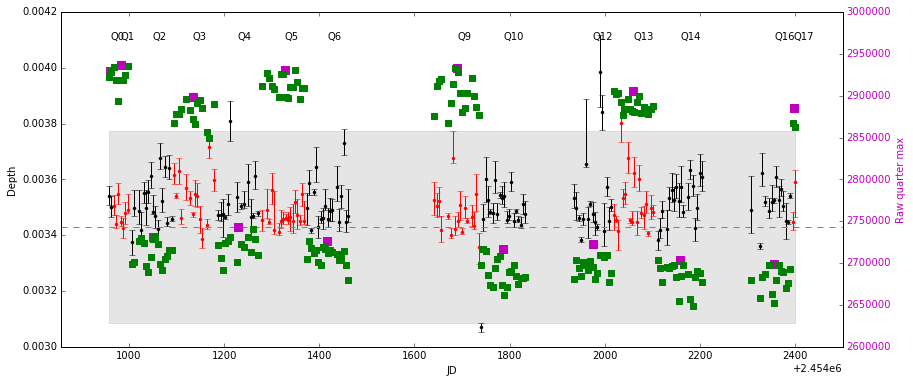

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(14, 6))
errs = np.vstack([depth_err_low, depth_err_high])
quarter_times = [np.mean(np.array(times)[np.argwhere(np.array(quarters) == i)]) for i in set(quarters)]
for t, d, e, q in zip(times, depths, errs.T, quarters):
    e2 = [[e[0]], [e[1]]]
    ax1.errorbar(t, d, e2, fmt='.', color='k' if q % 2 == 0 else 'r')

ax2 = ax1.twinx()
qm = np.array(list(quarterly_maxes.items()))
qm_color = 'm'
quarterly_maxes_array = qm[:, 1]
ax2.scatter(quarter_times, quarterly_maxes_array, 
            color=qm_color, marker='s', s=50)

ax2.scatter(times, median_oot_flux, 
            color='g', marker='s', s=30)
    
for t_q, q in zip(quarter_times, set(quarters)):
    ax1.text(t_q, 0.0041, 'Q{0}'.format(q))

ax1.set_xlim(min(times)-100, max(times)+100)
ax1.set_xlabel('JD')
ax1.set_ylabel('Depth')
ax2.set_ylabel('Raw quarter max', color=qm_color)

depth_expected = 0.00343
depth_plus = 1.1*depth_expected
depth_minus = 0.9*depth_expected
ax1.axhline(depth_expected, ls='--', color='gray')
ax1.fill_between(times, depth_minus, depth_plus, alpha=0.2, color='gray')

for tl in ax2.get_yticklabels():
    tl.set_color(qm_color)


### Correlation between mean depth of each quarter and quarterly maximum

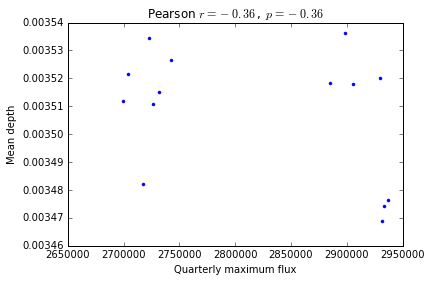

In [4]:
quarter_mean_depths = [np.mean(np.array(depths)[np.argwhere(np.array(quarters) == i)]) for i in set(quarters)]

plt.plot(quarterly_maxes_array, quarter_mean_depths, '.')

from scipy.stats import pearsonr

pr, p = pearsonr(quarterly_maxes_array, quarter_mean_depths)
plt.title('Pearson $r = {0:.2f}\,$, $\,p = {0:.2f}$'.format(pr, p))
plt.xlabel('Quarterly maximum flux')
plt.ylabel('Mean depth')

### Correlation between each depth and each quarterly max

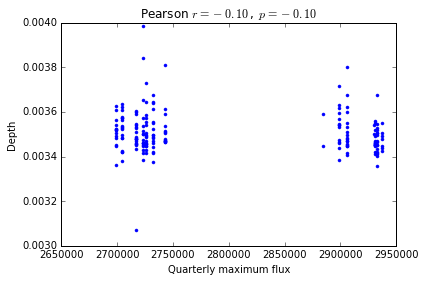

In [5]:
qm_each_max = [quarterly_maxes[q] for q in quarters]

plt.plot(qm_each_max, depths, '.')
pr, p = pearsonr(qm_each_max, depths)
plt.title('Pearson $r = {0:.2f}\,$, $\,p = {0:.2f}$'.format(pr, p))
plt.xlabel('Quarterly maximum flux')
plt.ylabel('Depth')

### Correlation between median OOT flux near each transit and best-fit depth

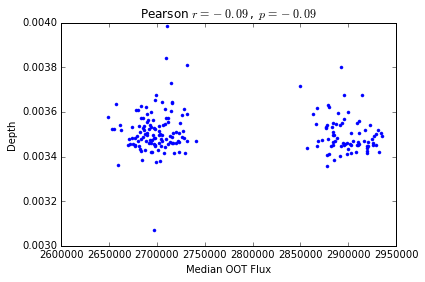

In [6]:
plt.plot(median_oot_flux, depths, '.')
pr, p = pearsonr(median_oot_flux, depths)
plt.title('Pearson $r = {0:.2f}\,$, $\,p = {0:.2f}$'.format(pr, p))
plt.xlabel('Median OOT Flux')
plt.ylabel('Depth')